# Реализация Deep Q-Network (DQN)

В этой домашней работе вам предстоит реализовать DQN — алгоритм приближенного Q-обучения с использованием опыта (experience replay) и целевых сетей (target networks) — и проверить, работает ли он лучше по сравнению с табличным Q-обучением.

Оригинальная статья:
https://arxiv.org/pdf/1312.5602.pdf

Референс задания взят из https://github.com/yandexdataschool/Practical_RL/tree/master/week04_approx_rl но адаптирован и доработан.

### Руководство по выполнению домашнего задания

Это домашнее задание состоит из двух частей на выбор, которые помогут вам освоить обучение с подкреплением. Сдать нужно одну из них. Первая "отладочная" часть может помочь быстрее отладить код для основного ноутбука, так как задания и код сильно пересекаются, но обучение в отладочной среде занимает гораздо меньше времени.

1. **Отладочный ноутбук (среда CartPole)**

* Что это: Это первая и более простая часть задания. В ней используется среда CartPole, где агент учится балансировать шест.
* Зачем начинать с него: Обучение здесь занимает всего несколько минут, что делает его идеальным для отладки вашего кода. Вы сможете быстро убедиться, что ваш алгоритм работает правильно, прежде чем переходить к более сложным задачам.
* Оценка: За выполнение основных заданий в этом ноутбуке вы можете получить 16 баллов. С помощью бонусных заданий вы сможете добрать оставшиеся баллы (до 12 бонусных баллов).

2. **Основной ноутбук (среда Atari)**

* Что это: Это вторая, более сложная часть. Здесь вы будете работать со средой Atari, что требует от агента решения более комплексных задач.
* Особенности: Обучение в этой среде занимает гораздо больше времени (около 2 часов), поэтому важно, чтобы ваш код был хорошо отлажен.
* Оценка:
    * Основные задания: За их успешное выполнение вы можете получить 20 баллов.
    * Бонусные задания: Если вы выполните эти задания, вы можете получить до 15 баллов, которые будут добавлены к вашей итоговой оценке за весь курс.


**Рекомендуемый порядок выполнения:**
Начните с ноутбука CartPole, чтобы отладить алгоритм, а затем перенесите его в ноутбук Atari для получения максимального результата и дополнительных баллов.

**Система получения баллов для наглядности преставлена табличкой**

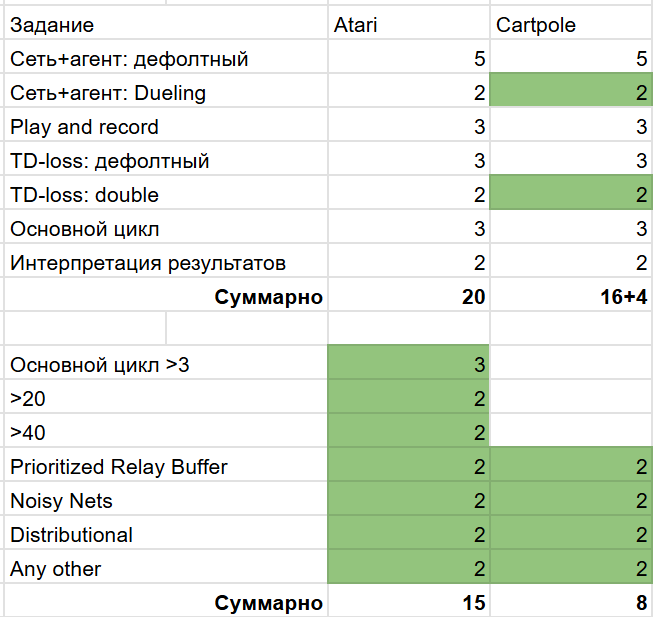

In [63]:
import sys, os
if not os.path.exists('.setup_complete'):
    os.makedirs('dqn', exist_ok=True)
    #!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh   -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/atari_wrappers.py   -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/utils.py   -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/replay_buffer.py   -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/framebuffer.py   -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/analysis.py   -P dqn/

    %pip install gymnasium

    !touch .setup_complete

# Этот код создает виртуальный дисплей для отрисовки изображений игры.
# Он не будет иметь никакого эффекта, если на вашем компьютере есть монитор.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [64]:
import random
import numpy as np
import torch
import dqn.utils

In [65]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Среда CartPole

Для этого задания можно использовать и другие среды без каких-либо изменений кода. Пространство состояний должно быть представлено одним вектором, а действия — дискретными.

CartPole — самая простая из них. Для ее решения потребуется всего несколько минут.

In [66]:
ENV_NAME = "CartPole-v1"


def make_env():
    # некоторые среды по умолчанию обернуты в оболочку с ограничением по времени
    env = gym.make(ENV_NAME, render_mode="rgb_array").unwrapped
    return env

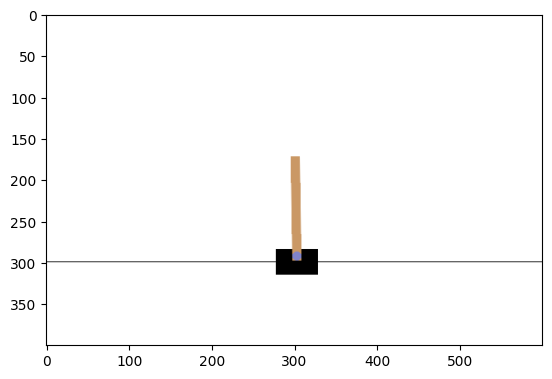

In [67]:
env = make_env()
env.reset()
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n

### Построение нейронной сети и агента (5 баллов)

Теперь нам нужно построить нейронную сеть, которая будет преобразовывать наблюдения (состояния) в значения Q-функции (q-values).
Модель не обязательно должна быть огромной. 1-2 скрытых слоя с менее чем 200 нейронами и активацией ReLU, скорее всего, будут достаточны. Использование Batch Normalization и Dropout здесь может ухудшить результаты обучения.

In [68]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# те, у кого есть GPU, но считают несправедливым его использовать, могут раскомментировать:
# device = torch.device('cpu')
device

device(type='cpu')

In [69]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Определите архитектуру вашей нейронной сети здесь. Убедитесь, что агент полностью содержится в этом классе.
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        ### ВАШ КОД
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )
        ###ВАШ КОД ЗАКОНЧИЛСЯ


    def forward(self, state_t):
        """
        Принимает наблюдение агента (тензор), возвращает q-значения (тензор)
        :param state_t: пакет состояний, форма = [batch_size, *state_dim=4]
        """
        # Используйте вашу сеть для вычисления q-значений для заданного состояния
        ### ВАШ КОД
        qvalues = self.network(state_t)
        ###ВАШ КОД ЗАКОНЧИЛСЯ

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and
            qvalues.shape[0] == state_t.shape[0] and
            qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        Аналогично forward, но работает с numpy-массивами, а не с тензорами
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        ### ВАШ КОД
        qvalues = self.forward(states)
        ### ВАШ КОД ЗАКОНЧИЛСЯ
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """Выбирает действия на основе q-значений. Использует стратегию epsilon-жадного исследования. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        ### ВАШ КОД
        # Генерируем случайные числа от 0 до 1
        random_numbers = np.random.rand(batch_size)
        should_explore = random_numbers < epsilon  # булев массив

        random_actions = np.random.randint(0, n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        actions = np.where(should_explore, random_actions, best_actions)
        return actions
        ### ВАШ КОД ЗАКОНЧИЛСЯ

In [70]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Теперь давайте попробуем запустить нашего агента, чтобы убедиться, что он не вызывает ошибок.

In [71]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, seed=None):
    """ Играет n_games полных игр. Если greedy=True, выбирает действия как argmax(qvalues). Возвращает среднее вознаграждение. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

### Хранение опыта (Experience Replay)
Для этого задания мы предоставляем вам буфер для хранения опыта. Если вы реализовали буфер хранения опыта в прошлой домашней работе, вы можете скопировать его сюда в основной ноутбук **чтобы получить 2 бонусных балла**.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

Интерфейс довольно прост:
* `exp_replay.add(obs, act, rw, next_obs, done)` - сохраняет кортеж (s,a,r,s',done) в буфер
* `exp_replay.sample(batch_size)` - возвращает наблюдения, действия, награды, следующие наблюдения и флаги завершения эпизода для `batch_size` случайных образцов.
* `len(exp_replay)` - возвращает количество элементов, хранящихся в буфере воспроизведения.

In [72]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Создаёт буфер воспроизведения.
        Параметры
        ----------
        size: int
            Максимальное количество переходов, которые можно хранить в буфере.
            При переполнении буфера старые записи удаляются.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.asarray(obs_t))
            actions.append(np.asarray(action))
            rewards.append(reward)
            obses_tp1.append(np.asarray(obs_tp1))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones),
        )

    def sample(self, batch_size):
        """Выбирает случайную партию переходов из буфера.
        Параметры
        ----------
        batch_size: int
            Сколько переходов нужно выбрать.
        Возвращает
        -------
        obs_batch: np.array
            партия наблюдений
        act_batch: np.array
            партия действий, выполненных в состоянии obs_batch
        rew_batch: np.array
            вознаграждения, полученные в результате выполнения act_batch
        next_obs_batch: np.array
            следующие наблюдения после выполнения act_batch
        done_mask: np.array
            done_mask[i] = 1, если выполнение act_batch[i] привело к завершению эпизода,
            и 0 в противном случае.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [73]:
#from dqn.replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "размер буфера опыта должен быть 10, так как это максимальная емкость"

### Play and record (3 балла)

In [74]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Играет в игру ровно n_steps шагов, записывая каждый кортеж (s,a,r,s', done) в буфер воспроизведения.
    Всякий раз, когда игра заканчивается (terminated или truncated), добавляется запись с done=terminated и игра сбрасывается.
    Гарантируется, что среда имеет terminated=False при передаче в эту функцию.

    НЕ СБРАСЫВАЙТЕ СРЕДУ, ЕСЛИ ОНА НЕ ЗАВЕРШЕНА (done)

    :returns: возвращает сумму наград за время игры и состояние, в котором осталась среда
    """
    s = initial_state
    sum_rewards = 0

    # Играйте в игру в течение n_steps, как указано в инструкциях выше
    ### ВАШ КОД
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, terminated, truncated, done = env.step(action)
        sum_rewards += r
        exp_replay.add(s, action, r, next_s, terminated or truncated)
        if terminated or truncated:
            s, _ = env.reset()
        else:
            s = next_s
    ###ВАШ КОД ЗАКОНЧИЛСЯ

    return sum_rewards, s

In [75]:
# тестирование вашего кода.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# если вы используете свой собственный буфер опыта, некоторые из этих тестов могут потребовать корректировки.
# просто убедитесь, что вы понимаете, что делает ваш код
assert len(exp_replay) == 1000, \
    "play_and_record должен был добавить ровно 1000 шагов, " \
    "но вместо этого добавил %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, \
    "Пожалуйста, убедитесь, что вы перезапускаете игру, когда она 'завершена', и " \
    "правильно записываете флаг is_done в буфер. Получена частота is_done %f за " \
    "%i шагов. [Если вы считаете, что вам просто не повезло, просто перезапустите тест]" % (
        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), \
        "пакет действий должен иметь форму (10,), но имеет %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "пакет наград должен иметь форму (10,), но имеет %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "пакет is_done должен иметь форму (10,), но имеет %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done должен быть строго True или False"
    assert [0 <= a < n_actions for a in act_batch], "действия должны быть в диапазоне [0, n_actions)"

print("Отлично!")

Отлично!


### Целевые сети (Target Networks)

Мы также используем так называемую "целевую сеть" — копию весов нейронной сети, которая используется для вычисления опорных Q-значений:

Сама сеть является точной копией сети агента, но ее параметры не обучаются. Вместо этого они периодически копируются сюда из основной сети агента.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [76]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# Это то, как вы можете загрузить веса из агента в целевую сеть
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Обучение с помощью Q-обучения, TD-loss (3 балла)
Здесь мы напишем функцию, аналогичную `agent.update` из табличного Q-обучения.

Вычислим ошибку TD для Q-обучения:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

Где Q-reference определяется как

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Где
* $Q_{target}(s',a')$ обозначает Q-значение следующего состояния и следующего действия, предсказанное __целевой сетью__
* $s, a, r, s'$ — текущее состояние, действие, награда и следующее состояние соответственно
* $\gamma$ — коэффициент дисконтирования, определенный двумя ячейками выше.


__Примечание 1:__ Ниже приведен пример входных данных. Не стесняйтесь экспериментировать с ним перед написанием функции.

__Примечание 2:__ Функция `compute_td_loss` является источником 99% ошибок в этой домашней работе. Если награда не улучшается, часто помогает пройтись по ней построчно [с резиновой уткой](https://rubberduckdebugging.com/).

In [77]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Вычислите TD-ошибку, используя только операции torch. Используйте приведенные выше формулы. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # получаем q-значения для всех действий в текущих состояниях
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # вычисляем q-значения для всех действий в следующих состояниях
    ### ВАШ КОД
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    ###ВАШ КОД ЗАКОНЧИЛСЯ

    # выбираем q-значения для выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # вычисляем V*(next_states) с использованием предсказанных следующих q-значений
    ### ВАШ КОД
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    ###ВАШ КОД ЗАКОНЧИЛСЯ

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "должно предсказываться одно значение на состояние"

    # вычисляем "целевые q-значения" для потерь - это то, что внутри квадратных скобок в приведенной выше формуле.
    # для последнего состояния используем упрощенную формулу: Q(s,a) = r(s,a), так как s' не существует
    # вы можете умножить значения следующего состояния на is_not_done, чтобы добиться этого.
    ### ВАШ КОД
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
    ###ВАШ КОД ЗАКОНЧИЛСЯ

    # среднеквадратичная ошибка потерь для минимизации
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert next_state_values.data.dim() == 1, \
            "убедитесь, что вы вычислили V(s') как максимум только по оси действий, а не по всем осям"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss

Проверка работоспособности

In [78]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), \
    "вы должны вернуть скалярную потерю - среднее значение по батчу"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), \
    "потеря должна быть дифференцируемой по отношению к весам сети"
assert np.all(next(target_network.parameters()).grad is None), \
    "целевая сеть не должна иметь градиентов"

### Основной цикл обучения (3 балла)

Пришло время собрать все вместе и посмотреть, научится ли агент чему-нибудь.

In [79]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [80]:
seed = 42 # <YOUR CODE: your favourite random seed>
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [81]:
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset(seed=seed)

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [82]:
from dqn.utils import is_enough_ram, linear_decay

REPLAY_BUFFER_SIZE = 10**4

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in range(100):
    if not is_enough_ram(min_available_gb=0.1):
        print("""
            Доступно менее 100 Мб оперативной памяти.
            Убедитесь, что размер буфера не слишком велик.
            Также проверьте, возможно, другие процессы сильно потребляют оперативную память.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

10000


In [83]:
# # для чего-то более сложного, чем CartPole

# timesteps_per_epoch = 1
# batch_size = 32
# total_steps = 3 * 10**6
# decay_steps = 1 * 10**6

# opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# init_epsilon = 1
# final_epsilon = 0.1

# loss_freq = 20
# refresh_target_network_freq = 1000
# eval_freq = 5000

# max_grad_norm = 5000

In [84]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 4 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 5000

In [85]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [86]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

размер буфера = 10000, epsilon = 0.10000


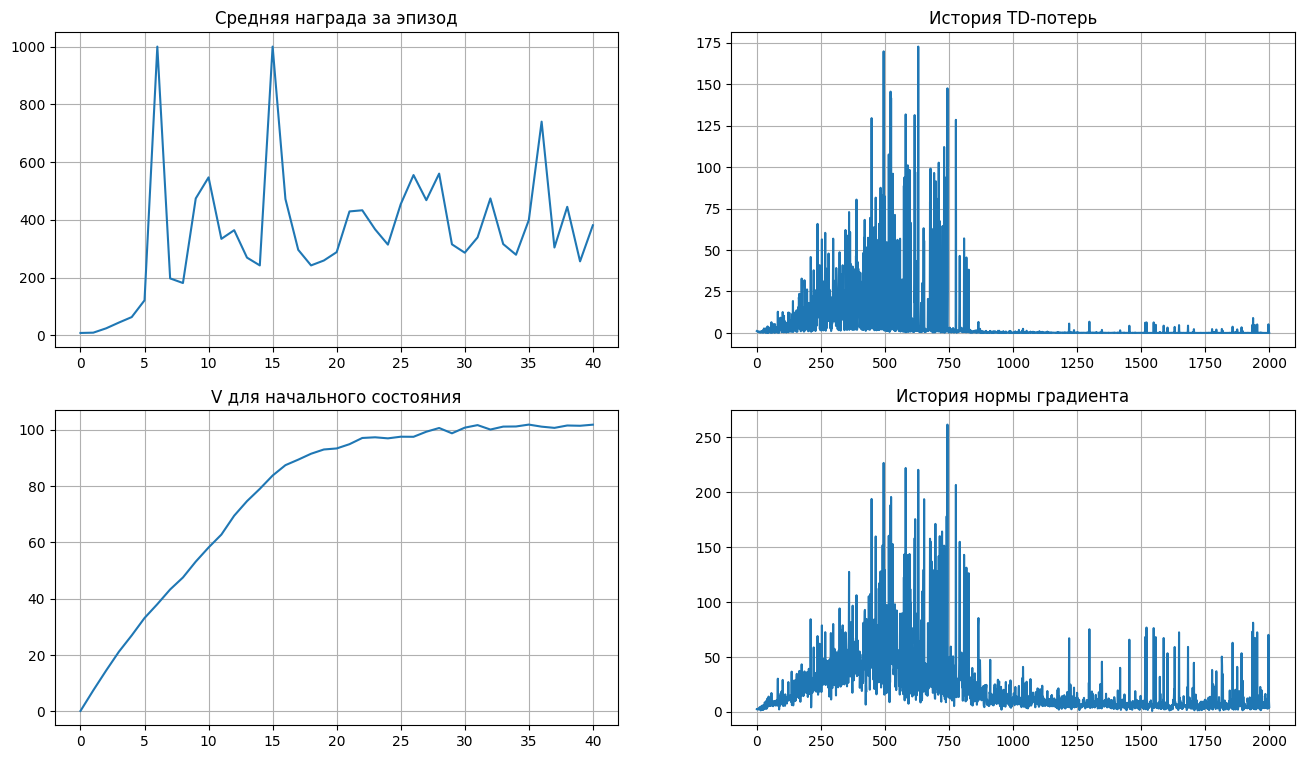

100%|██████████| 40001/40001 [01:51<00:00, 357.35it/s]


In [87]:
state, _ = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not is_enough_ram():
            print('доступно менее 100 Мб оперативной памяти, приостановка')
            print('убедитесь, что все в порядке, и используйте KeyboardInterrupt для продолжения')
            wait_for_keyboard_interrupt()

        agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # играем
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # обучаемся
        ### ВАШ КОД: возьмите сэмпл размера batch_size из буфера опыта
        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
        ###ВАШ КОД ЗАКОНЧИЛСЯ

        ### ВАШ КОД: вычислите TD-потери
        loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, agent, target_network)
        ###ВАШ КОД ЗАКОНЧИЛСЯ

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm)

        if step % refresh_target_network_freq == 0:
            # Загрузите веса агента в целевую сеть
            ### ВАШ КОД
            target_network.load_state_dict(agent.state_dict())
            ###ВАШ КОД ЗАКОНЧИЛСЯ

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(), agent, n_games=3, greedy=True, t_max=1000, seed=step)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env().reset(seed=step)[0]]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("размер буфера = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Средняя награда за эпизод")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("История TD-потерь")
            plt.plot(td_loss_history)
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("V для начального состояния")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("История нормы градиента")
            plt.plot(grad_norm_history)
            plt.grid()

            plt.show()

In [88]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('итоговый результат:', final_score)
assert final_score > 300, 'недостаточно хорошо для DQN'
print('Отлично')

итоговый результат: 452.03333333333336
Отлично


### Сравнение предсказанных агентом V-значений с их оценками методом Монте-Карло (2 балла)

In [89]:
from dqn.analysis import play_and_log_episode

eval_env = make_env()
record = play_and_log_episode(eval_env, agent)
print('общая награда за эпизод:', np.sum(record['rewards']))
for key in record:
    print(key)

общая награда за эпизод: 507.0
states
qvalues
actions
rewards
episode_finished


Построив scatter plot v_mc против v_agent, мы можем визуально оценить, насколько хорошо предсказания агента согласуются с реальным опытом. Если агент обучен хорошо, точки должны лежать близко к линии x=y. Отклонения могут указывать на переоценку или недооценку агентом ценности состояний.

In [90]:
def get_discounted_returns(rewards, gamma) -> list[float]:
    """
    Вычисляет G[t] для каждого t, учитывая награды и гамму.

    Совет: Итерируйте в обратном порядке по наградам и используйте следующее соотношение:
    G[t] = r[t] + gamma * G[t + 1]
    """
### ВАШ КОД
    returns = []
    G = 0.0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns = returns[::-1]  # Reverse the list to match original order
    return returns
###ВАШ КОД ЗАКОНЧИЛСЯ

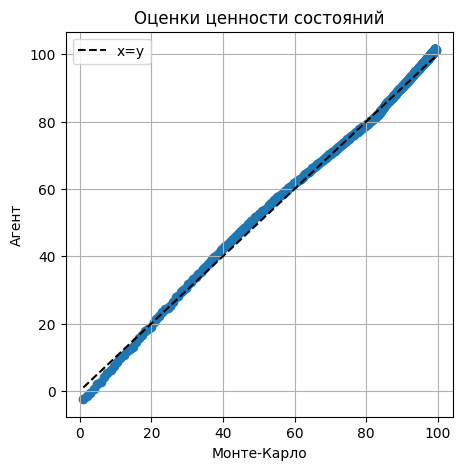

In [91]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Вычисляем V-значения по Монте-Карло и по агенту
v_mc = get_discounted_returns(record['rewards'], 0.99)#np.array([np.sum(record['rewards'][i:] * (0.99 ** np.arange(len(record['rewards']) - i)))
#                 for i in range(len(record['rewards']))])
v_agent = np.max(record['qvalues'], axis=1)

ax.scatter(v_mc, v_agent)
ax.plot(sorted(v_mc), sorted(v_mc),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('Оценки ценности состояний')
ax.set_xlabel('Монте-Карло')
ax.set_ylabel('Агент')

plt.show()

# Бонус: Дуэльный DQN и Double TD-loss (2+2 балла)

In [92]:
import torch
import torch.nn as nn
import numpy as np

class DuelingDQNHead(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(DuelingDQNHead, self).__init__()
        ### ВАШ КОД
        # advantage_stream: линейный слой -> ReLU -> линейный слой -> n_actions
        # value_stream: линейный слой -> ReLU -> линейный слой -> 1
        self.advantage_stream = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
        self.value_stream = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        ###ВАШ КОД ЗАКОНЧИЛСЯ

    def forward(self, x):
        ### ВАШ КОД
        advantages = self.advantage_stream(x)
        values = self.value_stream(x)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values
###ВАШ КОД ЗАКОНЧИЛСЯ

In [93]:
class DuelingDQN(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(DuelingDQN, self).__init__()
        state_dim = state_shape[0]
        ### ВАШ КОД
        # feature_extractor: линейный -> ReLU -> линейный -> ReLU
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 192),
            nn.ReLU()
        )
        ###ВАШ КОД ЗАКОНЧИЛСЯ
        self.dueling_head = DuelingDQNHead(192, n_actions)

    def forward(self, x):
        features = self.feature_extractor(x)
        qvals = self.dueling_head(features)
        return qvals

In [94]:
class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        assert len(state_shape) == 1
        ### ВАШ КОД
        # Используйте DuelingDQN как q_network
        self.q_network = DuelingDQN(state_shape, n_actions)
        ###ВАШ КОД ЗАКОНЧИЛСЯ

    def forward(self, state_t):
        """
        Принимает наблюдение агента (тензор), возвращает q-значения (тензор)
        :param state_t: пакет состояний, форма = [batch_size, *state_dim=4]
        """
        qvalues = self.q_network(state_t)
        #UPD: этот assert можно закомментить на время обучения с double DQN
        #assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and
            qvalues.shape[0] == state_t.shape[0] and
            qvalues.shape[1] == self.n_actions
        )
        return qvalues

    def get_qvalues(self, states):
        """
        Аналогично forward, но работает с numpy-массивами, а не с тензорами
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues, greedy=False):
        """
        Выбирает действия на основе q-значений. Использует стратегию epsilon-жадного исследования.
        """
        if greedy:
            return qvalues.argmax(axis=-1)

        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        ### ВАШ КОД
        random_numbers = np.random.rand(batch_size)
        should_explore = random_numbers < epsilon  # булев массив

        random_actions = np.random.randint(0, n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        actions = np.where(should_explore, random_actions, best_actions)
        return actions
        ###ВАШ КОД ЗАКОНЧИЛСЯ

In [95]:
def compute_td_loss_double(
    states: torch.Tensor,  # (batch_size, *state_shape)
    actions: torch.Tensor,  # (batch_size,)
    rewards: torch.Tensor,  # (batch_size,)
    next_states: torch.Tensor,  # (batch_size, *state_shape)
    is_done: torch.Tensor,  # (batch_size,), torch.bool
    agent: nn.Module,
    target_network: nn.Module,
    gamma: float = 0.99,
    check_shapes=False,
):
    predicted_qvalues = agent(states)  # форма: [batch_size, n_actions]
    assert is_done.dtype is torch.bool

    # вычисляем q-значения для всех действий в следующих состояниях
### ВАШ КОД
#    with torch.no_grad():
#        predicted_next_qvalues_agent = ...
#        predicted_next_qvalues_target = ...
###ВАШ КОД ЗАКОНЧИЛСЯ

### ВАШ КОД (UPD)
    with torch.no_grad():
        predicted_next_qvalues_agent = agent(next_states) #позволяет градиентам распространяться через ошибку выбора действия
        predicted_next_qvalues_target = target_network(next_states)  #предотвращаем градиенты от распространения через target_network
###ВАШ КОД ЗАКОНЧИЛСЯ

    # выбираем q-значения для выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[
        range(len(actions)), actions
    ]  # форма: [batch_size]

    # вычисляем V*(next_states) используя предсказанные q-значения следующих состояний
### ВАШ КОД
    next_state_values = predicted_next_qvalues_target[
        range(len(actions)),
        predicted_next_qvalues_agent.argmax(dim=1)
    ]  # Double DQN: используем argmax от агента, но значения от target
###ВАШ КОД ЗАКОНЧИЛСЯ

    if check_shapes:
        assert (
            next_state_values.dim() == 1
            and next_state_values.shape[0] == states.shape[0]
        ), "должно предсказываться одно значение на состояние"
        assert not next_state_values.requires_grad

    # вычисляем "целевые q-значения" для ошибки - это то, что в квадратных скобках в формуле выше.
    # в последнем состоянии используем упрощенную формулу: Q(s,a) = r(s,a), так как s' не существует
### ВАШ КОД
    is_not_done = 1 - is_done.float()
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
###ВАШ КОД ЗАКОНЧИЛСЯ

    # среднеквадратичная ошибка для минимизации
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues_target.data.dim() == 2
        ), "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert (
            next_state_values.data.dim() == 1
        ), "убедитесь, что вы вычислили V(s') как максимум только по оси действий, а не по всем осям"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss

In [96]:
# Инициализируем агента и целевую сеть
dueling_agent = DuelingDQNAgent(state_shape, n_actions, epsilon=0.1).to(device)
dueling_target_network = DuelingDQNAgent(state_shape, n_actions, epsilon=0.1).to(device)
dueling_target_network.q_network.load_state_dict(dueling_agent.q_network.state_dict())

agent=dueling_agent  #если хотите потестировать Dueling DQN
target_network = dueling_target_network

In [97]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 4 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 5000

In [98]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

размер буфера = 10000, epsilon = 0.10000


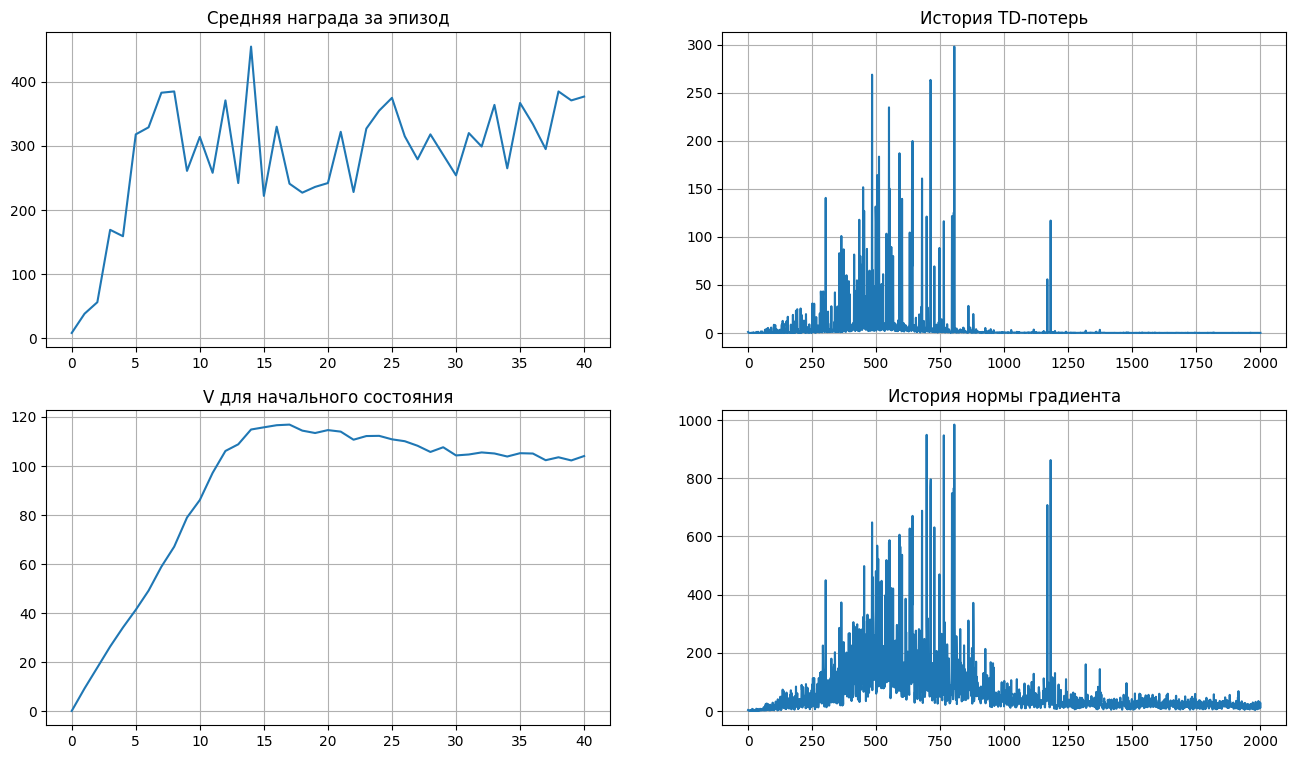

100%|██████████| 40001/40001 [06:04<00:00, 109.61it/s]


In [99]:
state, _ = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not is_enough_ram():
            print('доступно менее 100 Мб оперативной памяти, приостановка')
            print('убедитесь, что все в порядке, и используйте KeyboardInterrupt для продолжения')
            wait_for_keyboard_interrupt()

        agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # играем
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # обучаемся
        ### ВАШ КОД: возьмите сэмпл размера batch_size из буфера опыта
        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
        ###ВАШ КОД ЗАКОНЧИЛСЯ

        ### ВАШ КОД: вычислите TD-потери
            # Convert numpy arrays to tensors if needed
        states = torch.tensor(obs_batch, device=device, dtype=torch.float32) if not isinstance(obs_batch, torch.Tensor) else obs_batch
        actions = torch.tensor(act_batch, device=device, dtype=torch.int64) if not isinstance(act_batch, torch.Tensor) else act_batch
        rewards = torch.tensor(reward_batch, device=device, dtype=torch.float32) if not isinstance(reward_batch, torch.Tensor) else reward_batch
        next_states = torch.tensor(next_obs_batch, device=device, dtype=torch.float32) if not isinstance(next_obs_batch, torch.Tensor) else next_obs_batch
        is_done = torch.tensor(is_done_batch, device=device, dtype=torch.bool) if not isinstance(is_done_batch, torch.Tensor) else is_done_batch

        loss = compute_td_loss_double(states, actions, rewards, next_states, is_done, agent, target_network)
        ###ВАШ КОД ЗАКОНЧИЛСЯ

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm)

        if step % refresh_target_network_freq == 0:
            # Загрузите веса агента в целевую сеть
            ### ВАШ КОД
            target_network.load_state_dict(agent.state_dict())
            ###ВАШ КОД ЗАКОНЧИЛСЯ

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(), agent, n_games=3, greedy=True, t_max=1000, seed=step)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env().reset(seed=step)[0]]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("размер буфера = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Средняя награда за эпизод")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("История TD-потерь")
            plt.plot(td_loss_history)
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("V для начального состояния")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("История нормы градиента")
            plt.plot(grad_norm_history)
            plt.grid()

            plt.show()

In [100]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('итоговый результат:', final_score)
assert final_score > 300, 'недостаточно хорошо для DQN'
print('Отлично')

итоговый результат: 389.0
Отлично


In [101]:
eval_env = make_env()
record = play_and_log_episode(eval_env, agent)
print('общая награда за эпизод:', np.sum(record['rewards']))

общая награда за эпизод: 384.0


Text(0, 0.5, 'Агент')

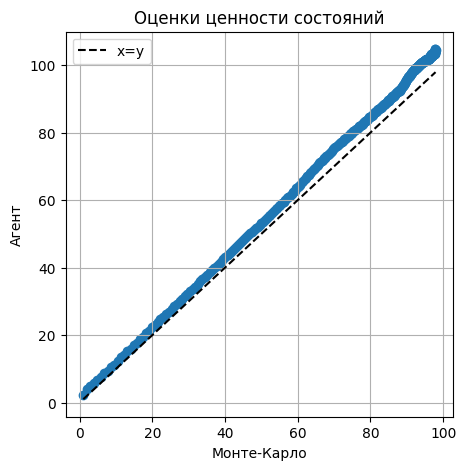

In [102]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Вычисляем V-значения по Монте-Карло и по агенту
v_mc = get_discounted_returns(record['rewards'], 0.99)#np.array([np.sum(record['rewards'][i:] * (0.99 ** np.arange(len(record['rewards']) - i)))
#                 for i in range(len(record['rewards']))])
v_agent = np.max(record['qvalues'], axis=1)

ax.scatter(v_mc, v_agent)
ax.plot(sorted(v_mc), sorted(v_mc),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('Оценки ценности состояний')
ax.set_xlabel('Монте-Карло')
ax.set_ylabel('Агент')

# Бонус II (8 баллов). Примените модификации к DQN.

* [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (2 балла, пожалуйста, проверьте наличие эффективных реализаций с открытым исходным кодом)


In [103]:
from dqn.prioritized_replay_buffer import PrioritizedReplayBuffer
from dqn.utils import is_enough_ram, linear_decay
from dqn.analysis import play_and_log_episode

In [104]:
def compute_td_loss_with_prioritization(states, actions, rewards, next_states, is_done,
                                        weights,
                                        agent, target_network,
                                        gamma=0.99,
                                        check_shapes=False,
                                        device=device):
    """ Вычислить TD потери с приоритезацией, используя веса важности выборки. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # форма: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # форма: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # форма: [batch_size]
    # форма: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # форма: [batch_size]
    is_not_done = 1 - is_done
    
    # Преобразовать веса в тензор
    weights = torch.tensor(weights, device=device, dtype=torch.float32)

    # получить q-значения для всех действий в текущих состояниях
    predicted_qvalues = agent(states)  # форма: [batch_size, n_actions]

    # вычислить q-значения для всех действий в следующих состояниях
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states) # форма: [batch_size, n_actions]

    # выбрать q-значения для выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # форма: [batch_size]

    # вычислить V*(next_states), используя предсказанные следующие q-значения
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "должен предсказывать одно значение для каждого состояния"

    # вычислить "целевые q-значения" для потерь - это то, что внутри квадратных скобок в формуле выше.
    # для последнего состояния использовать упрощенную формулу: Q(s,a) = r(s,a), так как s' не существует
    # можно умножить next_state_values на is_not_done, чтобы достичь этого
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    # вычислить TD ошибки
    td_errors = (predicted_qvalues_for_actions - target_qvalues_for_actions).abs()
    
    # вычислить взвешенные MSE потери
    loss = (weights * (predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2).mean()

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "убедитесь, что вы предсказали q-значения для всех действий в next_state"
        assert next_state_values.data.dim() == 1, \
            "убедитесь, что вы вычислили V(s') как максимум только по оси действий, а не по всем осям"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss, td_errors


In [ ]:
def train_with_prioritized_replay():
    """Основной цикл обучения с приоритетной выборкой опыта."""
    
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    state_dim = env.observation_space.shape
    n_actions = env.action_space.n
    state, _ = env.reset(seed=seed)

    agent = DuelingDQNAgent(state_dim, n_actions, epsilon=1).to(device)
    target_network = DuelingDQNAgent(state_dim, n_actions, epsilon=1).to(device)
    target_network.q_network.load_state_dict(agent.q_network.state_dict())

    # Использовать приоритетный буфер воспроизведения вместо обычного буфера воспроизведения
    REPLAY_BUFFER_SIZE = 10**4
    exp_replay = PrioritizedReplayBuffer(REPLAY_BUFFER_SIZE)

    # Заполнить буфер
    for i in range(100):
        if not is_enough_ram(min_available_gb=0.1):
            print("""
                Доступно менее 10 Мб оперативной памяти.
                Убедитесь, что размер буфера не слишком большой.
                Также проверьте, не потребляют ли другие процессы много оперативной памяти.
                """)
            break
        play_and_record(state, agent, env, exp_replay, n_steps=10**2)
        if len(exp_replay) == REPLAY_BUFFER_SIZE:
            break
    print(f"Буфер заполнен. Размер: {len(exp_replay)}")

    # Параметры обучения
    timesteps_per_epoch = 1
    batch_size = 32
    total_steps = 4 * 10**4
    decay_steps = 1 * 10**4

    opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

    init_epsilon = 1
    final_epsilon = 0.1

    loss_freq = 20
    refresh_target_network_freq = 100
    eval_freq = 100

    max_grad_norm = 5000

    mean_rw_history = []
    td_loss_history = []
    grad_norm_history = []
    initial_state_v_history = []
    step = 0

    import time

    def wait_for_keyboard_interrupt():
        try:
            while True:
                time.sleep(1)
        except KeyboardInterrupt:
            pass

    state, _ = env.reset()
    with trange(step, total_steps + 1) as progress_bar:
        for step in progress_bar:
            if not is_enough_ram():
                print('доступно менее 100 Мб оперативной памяти, пауза')
                print('убедитесь, что все в порядке, и используйте KeyboardInterrupt для продолжения')
                wait_for_keyboard_interrupt()

            agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

            # играть
            _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

            # обучать
            # Взять выборку размера batch_size из буфера опыта
            obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, idxes, weights = exp_replay.sample(batch_size)

            # Вычислить TD потери с приоритезацией
            loss, td_errors = compute_td_loss_with_prioritization(
                obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, 
                weights, agent, target_network
            )

            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            opt.step()
            opt.zero_grad()

            # Обновить приоритеты в буфере на основе TD ошибок
            exp_replay.update_priorities(idxes, td_errors.detach().cpu().numpy())

            if step % loss_freq == 0:
                td_loss_history.append(loss.data.cpu().item())
                grad_norm_history.append(grad_norm)

            if step % refresh_target_network_freq == 0:
                # Загрузить веса агента в целевую сеть
                target_network.load_state_dict(agent.state_dict())

            if step % eval_freq == 0:
                mean_rw_history.append(evaluate(
                    make_env(), agent, n_games=3, greedy=True, t_max=1000, seed=step)
                )
                initial_state_q_values = agent.get_qvalues(
                    [make_env().reset(seed=step)[0]]
                )
                initial_state_v_history.append(np.max(initial_state_q_values))

                clear_output(True)
                print("размер буфера = %i, epsilon = %.5f" %
                    (len(exp_replay), agent.epsilon))

                plt.figure(figsize=[16, 9])

                plt.subplot(2, 2, 1)
                plt.title("Средняя награда за эпизод")
                plt.plot(mean_rw_history)
                plt.grid()

                assert not np.isnan(td_loss_history[-1])
                plt.subplot(2, 2, 2)
                plt.title("История TD потерь")
                plt.plot(td_loss_history)
                plt.grid()

                plt.subplot(2, 2, 3)
                plt.title("V для начального состояния")
                plt.plot(initial_state_v_history)
                plt.grid()

                plt.subplot(2, 2, 4)
                plt.title("История нормы градиента")
                plt.plot(grad_norm_history)
                plt.grid()

                plt.show()

    final_score = evaluate(
      make_env(),
      agent, n_games=30, greedy=True, t_max=1000
    )
    print('итоговый счет:', final_score)
    assert final_score > 300, 'недостаточно хорошо для DQN'
    print('Отлично')

    # Анализ
    eval_env = make_env()
    record = play_and_log_episode(eval_env, agent)
    print('общая награда за эпизод:', np.sum(record['rewards']))
    for key in record:
        print(key)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)

    # Вычислить MC и оценки значения агента
    v_mc = get_discounted_returns(record['rewards'], 0.99)
    v_agent = np.max(record['qvalues'], axis=1)

    ax.scatter(v_mc, v_agent)
    ax.plot(sorted(v_mc), sorted(v_mc),
           'black', linestyle='--', label='x=y')

    ax.grid()
    ax.legend()
    ax.set_title('Оценки значений состояний')
    ax.set_xlabel('Монте-Карло')
    ax.set_ylabel('Агент')

    plt.show()
    
    return agent, target_network, mean_rw_history, td_loss_history, grad_norm_history, initial_state_v_history


размер буфера = 10000, эпсилон = 0.10000


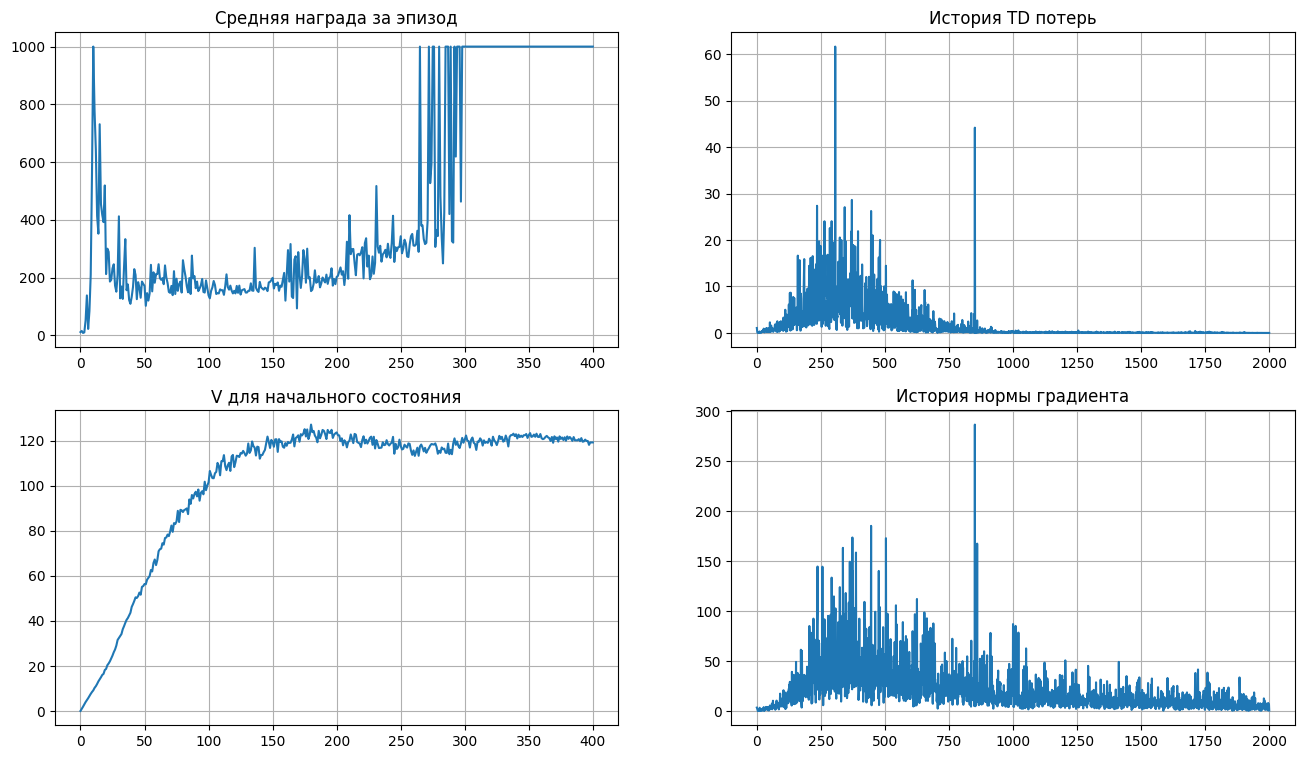

100%|██████████| 40001/40001 [09:26<00:00, 70.64it/s] 


итоговый счет: 1000.0
Отлично
общая награда за эпизод: 10000.0
states
qvalues
actions
rewards
episode_finished


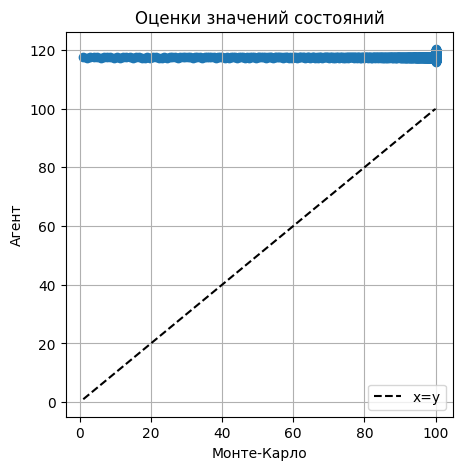

(DuelingDQNAgent(
   (q_network): DuelingDQN(
     (feature_extractor): Sequential(
       (0): Linear(in_features=4, out_features=256, bias=True)
       (1): ReLU()
       (2): Linear(in_features=256, out_features=192, bias=True)
       (3): ReLU()
     )
     (dueling_head): DuelingDQNHead(
       (advantage_stream): Sequential(
         (0): Linear(in_features=192, out_features=256, bias=True)
         (1): ReLU()
         (2): Linear(in_features=256, out_features=2, bias=True)
       )
       (value_stream): Sequential(
         (0): Linear(in_features=192, out_features=256, bias=True)
         (1): ReLU()
         (2): Linear(in_features=256, out_features=1, bias=True)
       )
     )
   )
 ),
 DuelingDQNAgent(
   (q_network): DuelingDQN(
     (feature_extractor): Sequential(
       (0): Linear(in_features=4, out_features=256, bias=True)
       (1): ReLU()
       (2): Linear(in_features=256, out_features=192, bias=True)
       (3): ReLU()
     )
     (dueling_head): DuelingDQNHead

In [107]:
train_with_prioritized_replay()


* [Noisy Nets](https://arxiv.org/abs/1706.10295) (2 балла, пожалуйста, обратите внимание на политику исследования и используется ли эпсилон-жадная политика)
* [Distributional RL](https://arxiv.org/abs/1707.06887) (distributional и distributed здесь означают разные вещи) (2 балла)
* Другие модификации (2 балла в зависимости от сложности)